# Multi-Resolution Modeling

This tutorial shows how to model sources frome images observed with different telescopes. We will use a multiband observation with the Hyper-Sprime Cam (HSC) and a single high-resolution image from the Hubble Space Telescope (HST).

In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

## Load and Display Data

We first load the HSC and HST images, swapping the byte order if necessary because a bug in astropy does not respect the local endianness.

In [2]:
# Load the HSC image data
obs_hdu = fits.open('../../data/test_resampling/Cut_HSC1.fits')
data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
wcs_hsc = WCS(obs_hdu[0].header)
channels_hsc = ['g','r','i','z','y']

# Load the HSC PSF data
psf_hsc = fits.open('../../data/test_resampling/PSF_HSC.fits')[0].data
Np1, Np2 = psf_hsc[0].shape
psf_hsc = scarlet.PSF(psf_hsc)

# Load the HST image data
hst_hdu = fits.open('../../data/test_resampling/Cut_HST1.fits')
data_hst = hst_hdu[0].data
wcs_hst = WCS(hst_hdu[0].header)
channels_hst = ['F814W']

# Load the HST PSF data
psf_hst = fits.open('../../data/test_resampling/PSF_HST.fits')[0].data
psf_hst = psf_hst[None,:,:]
psf_hst = scarlet.PSF(psf_hst)

# Scale the HST data
n1,n2 = np.shape(data_hst)
data_hst = data_hst.reshape(1, n1, n2).byteswap().newbyteorder()

r, N1, N2 = data_hsc.shape

Next we have to create a source catalog for the images. We'll use `sep` for that, but any other detection method will do. Since HST is higher resolution and less affected by blending, we use it for detection but we also run detection on the HSC image to calculate the background RMS:

In [3]:
import sep

class Data():
    #An object to have easier access to the data
    def __init__(self, images, wcss, psfs, channels):
        self.images = images
        self.wcs = wcss
        self.psfs = psfs.image
        self.channels = channels

def interpolate(data_lr, data_hr):
    #Interpolate the low resolution image to high resolution using sinc interpolation
    coord_lr0 = (np.arange(data_lr.images.shape[1]), np.arange(data_lr.images.shape[1]))
    coord_hr = (np.arange(data_hr.images.shape[1]), np.arange(data_hr.images.shape[1]))
    coord_lr = scarlet.resampling.convert_coordinates(coord_lr0, data_lr.wcs, data_hr.wcs)
    
    interp = []
    for image in data_lr.images:
        interp.append(scarlet.interpolation.sinc_interp(image[None, :,:], coord_hr, coord_lr, angle=None)[0].T)
    return np.array(interp)
        
def makeCatalog(data_lr, data_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform 
    # of the sum of the high resolution images and the low resolution images interpolated to the high resolution grid
    #Interpolate LR to HR
    interp = interpolate(data_lr, data_hr)
    # Normalisation 
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    hr_images = data_hr.images/np.sum(data_hr.images, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(data_hr.images)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image
    # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for data in datas:
        img = data.images
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
        
    return catalog, np.array(bg_rms), detect_image

In [4]:
#Data
data_hr =  Data(data_hst, wcs_hst, psf_hst, channels_hst)
data_lr =  Data(data_hsc, wcs_hsc, psf_hsc, channels_hsc)
datas = [data_lr, data_hr]
# Making catalog. 
# With the wavelet option on, only the first 3 wavelet levels are used for detection. Set to 1 for better detection
wave = 1
lvl = 3
catalog_hst, bg_rms, detect = makeCatalog(data_lr, data_hr, lvl, wave)

weights_hst = np.ones_like(data_hst) / (bg_rms[1]**2)[:, None, None]
weights_hsc = np.ones_like(data_hsc) / (bg_rms[0]**2)[:, None, None]

Finally we can visualize both the multiband HSC and single band HST images in their native resolutions:

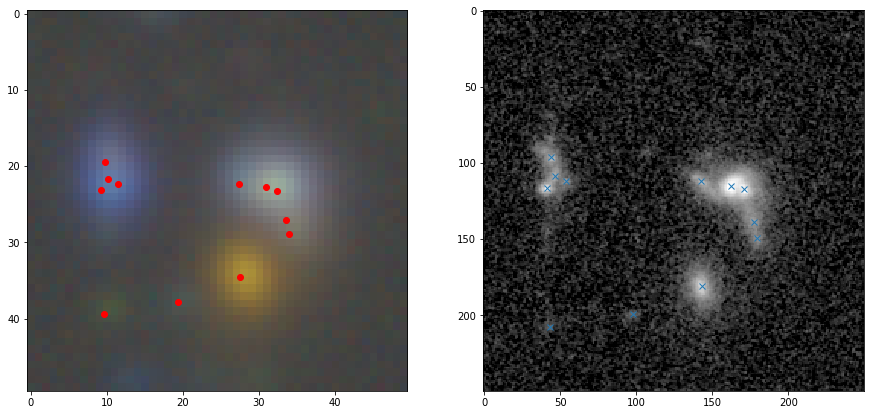

In [5]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=-1, stretch=2, Q=10)
hst_norm = AsinhMapping(minimum=-1, stretch=10, Q=5)

# Get the source coordinates from the HST catalog
xo,yo = catalog_hst['x'], catalog_hst['y']
# Convert the HST coordinates to the HSC WCS
ra, dec = wcs_hst.wcs_pix2world(yo,xo,0)

Yo,Xo, l = wcs_hsc.wcs_world2pix(ra, dec, 0, 0)
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(data_hsc, norm=hsc_norm)
# Apply Asinh to the HST data
hst_img = scarlet.display.img_to_rgb(data_hst, norm=hst_norm)

plt.figure(figsize=(15,30))
plt.subplot(121)
plt.imshow(img_rgb)
plt.plot(Xo,Yo, 'or')
plt.subplot(122)
plt.imshow(hst_img)
plt.plot(xo,yo, 'x')
plt.show()

## Create Frame and Observations

Unlike the single resolution examples, we now have two different instruments with different pixel resolutions, so we need two different observations. Since the HST image is at a much higher resolution, we define our model `Frame` to use the HST PSF and the HST resolution. Because there is no resampling between the model frame and the HST observation, we can use the default `Observation` class for the HST data. The HSC images have lower resolution, so we need to resample the models to this frame, and that's done by `LowResObservation`.

Users can specify frame, Observation and LowResObservation objects by hand and match them as is usually done in single observation fitting. Alternativelly, the user can provide a list of observation (no matter what the resolution of each observation is), from which the `from_observations` method will decide which observation(s) should be a LowResObservations. If no psf or reference wcs is provided, the method will also 

In [6]:
#Automated frame definition
# define two observation packages and match to frame
obs_hst = scarlet.Observation(data_hst, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst, weights=weights_hst)
obs_hsc = scarlet.Observation(data_hsc, wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc, weights=weights_hsc)

# Keep the order of the observations consistent with the `channels` parameter
# This implementation is a bit of a hack and will be refined in the future
obs = [obs_hsc, obs_hst]
frame = scarlet.Frame.from_observations(obs, coverage = 'intersection')
obs_hsc, obs_hst = obs

detect *= np.sum(data_hst)/np.sum(detect)
#Using the detection images to initialise sources. This helps make a joint decision across observations 
# in particular regarding box sizes
obs_detect = scarlet.Observation(detect[None,:,:], wcs=wcs_hst, psfs=psf_hst, channels=channels_hst)
obs_detects = [obs_hsc, obs_detect]
frame_detect = scarlet.Frame.from_observations(obs_detects, coverage = 'intersection')

## Initialize Sources and Blend

We expect all sources to be galaxies, so we initialized them as `ExtendedSources`. Because the initialization takes a list of observations, we set the `obs_idx` argument to state which observation in the list of observations is used to initialize the morphology.

`Blend` will hold a list of all sources and *all* observations to fit.

In [7]:
# For better detections, turn obs into obs_detect in sources
sources = [
    scarlet.ExtendedSource(frame_detect, (ra[i], dec[i]), obs, 
                           symmetric=False, 
                           monotonic=True, 
                           obs_idx=1)
    for i in range(ra.size)
]

blend = scarlet.Blend(sources, obs)

## Display Initial guess

Let's compare the initial guess of the model in both model frame and HSC observation frame:

CPU times: user 4.15 s, sys: 7.27 s, total: 11.4 s
Wall time: 11.2 s


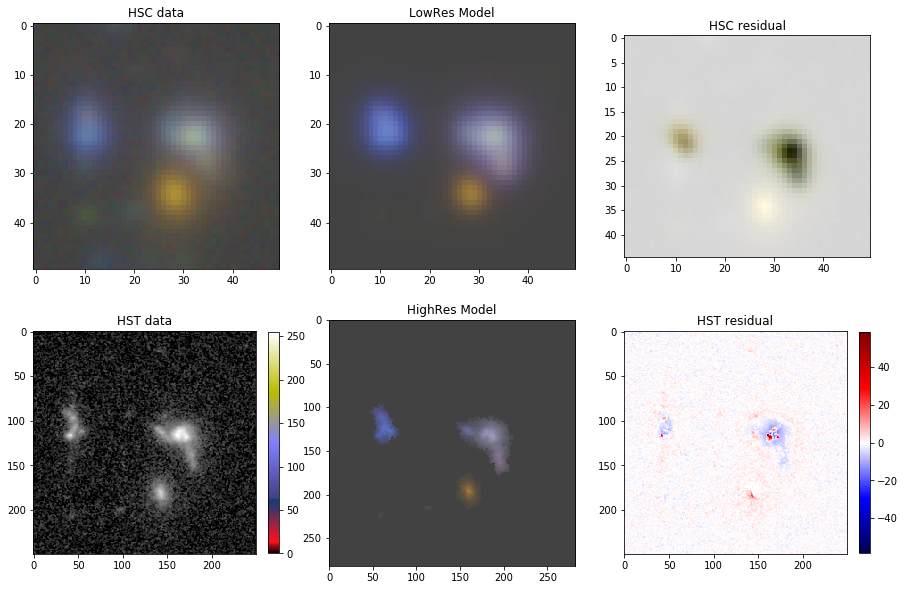

In [8]:
# Load the model and calculate the residual
model = blend.get_model()

%time obs_hsc.render(model)
model_lr = obs_hsc.render(model)
init_rgb = scarlet.display.img_to_rgb(model[:-1], norm=hsc_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5])

# Get the HR residual
residual_hr = (data_hst - obs_hst.render(model))[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.colorbar(fraction=.045)
plt.title('HST data')
plt.show()

## Fit Model

In [ ]:
%time blend.fit(20, e_rel = 1.e-5)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

### View Full Model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual to see the improvement from our initial guess.

In [ ]:
model = blend.get_model()
model_hr = obs_hst.render(model)
model_lr = obs_hsc.render(model)

rgb = scarlet.display.img_to_rgb(model[:-1], norm=hsc_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr

# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5], norm=hsc_norm)

# Get the HR residual
residual_hr = (data_hst - model_hr)[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.title("HSC data")
plt.subplot(235)
plt.imshow(rgb)
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.title('HST data')
plt.show()

### View Source Models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

In [ ]:
has_truth = False
axes = 2

for k,src in enumerate(blend.sources):
    print('source number ', k)
    # Get the model for a single source
    model = src.get_model()
    model_lr = obs_hsc.render(model)
    
    # Display the low resolution image and residuals
    img_lr_rgb = scarlet.display.img_to_rgb(model_lr, norm = hsc_norm)
    res = data_hsc-model_lr
    res_rgb = scarlet.display.img_to_rgb(res, norm = hsc_norm)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(331)
    plt.imshow(img_rgb)
    plt.plot(Xo[k],Yo[k], 'x', markersize = 10)
    plt.title("HSC Data")
    plt.subplot(332)
    plt.imshow(img_lr_rgb)
    plt.title("LR Model")
    plt.subplot(333)
    plt.imshow(res_rgb)
    plt.title("LR Data - Model")
    
    img_hr = obs_hst.render(model)
    res = data_hst-img_hr[-1]
    vmax = res.max()
    
    plt.subplot(334)
    plt.imshow(data_hst[0], cmap='gist_stern')
    plt.plot(xo[k],yo[k], 'o', markersize = 5)
    plt.title("HST Data")
    plt.subplot(335)
    plt.imshow(img_hr[-1])
    plt.title("HR Model")
    plt.subplot(336)
    plt.imshow(res[0], cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.title("HR Data - Model")
    
    plt.show()